In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_dir = "../river/rivertile"


files =  [os.path.join(file_dir, fn) for fn in os.listdir(file_dir) if fn.endswith('_nodes.shp')]


# Let's plot one of these files to look at how they are represented
fn1 = files[0]
gdf1 = gpd.read_file(fn1)

nodata_val = -999999999999.0
gdf1_filtered = gdf1[gdf1['wse'] != nodata_val]
gdf1_filtered['date'] = gdf1_filtered['time_str'].apply(lambda val: pd.to_datetime(val.split('T')[0]))
gdf1_filtered.head()


/Users/pdas47/opt/anaconda3/envs/sc/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,reach_id,node_id,time,time_tai,time_str,lat,lon,lat_u,lon_u,river_name,...,p_wse_var,p_width,p_wid_var,p_dist_out,p_length,p_dam_id,p_n_ch_max,p_n_ch_mod,geometry,date
504,44250000201,44250000200451,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.035078,105.863843,0.000007,0.000046,*,...,0.000347,779.0,218.250000,870822.546,211.430920,0,1,1,POINT (105.86323 15.03456),2021-11-30
505,44250000201,44250000200461,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.036048,105.860900,0.000004,0.000023,*,...,0.000306,918.0,5771.061224,871038.950,216.404335,0,1,1,POINT (105.86248 15.03633),2021-11-30
506,44250000201,44250000200471,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.038595,105.864219,0.000003,0.000020,*,...,0.000000,898.0,560.222222,871235.854,196.903696,0,2,1,POINT (105.86221 15.03809),2021-11-30
507,44250000201,44250000200481,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.040455,105.862183,0.000004,0.000026,*,...,0.000000,853.0,1090.640000,871427.948,192.093782,0,1,1,POINT (105.86122 15.03952),2021-11-30
508,44250000201,44250000200491,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.039840,105.859207,0.000004,0.000029,*,...,0.000000,801.0,2716.560000,871616.608,188.660753,0,1,1,POINT (105.85984 15.04058),2021-11-30


Text(0.5, 1.0, 'Observation Date: 2021-11-30 00:00:00')

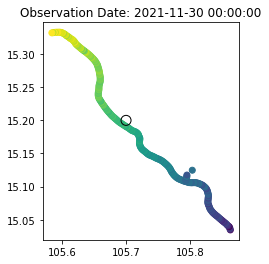

In [3]:
virtual_station = Point(105.7, 15.2)
virtual_station_gdf = gpd.GeoDataFrame({'name': ['virtual station 1']}, geometry=[virtual_station], crs='EPSG:4326')

obs_date = gdf1_filtered['date'].iloc[0]

gdf1_filtered.plot('wse')  # plotting the WSE from SWOT
plt.scatter(virtual_station.x, virtual_station.y, marker='o', s=100, ec='black', fc='none')
plt.title(f"Observation Date: {obs_date}")

In [5]:
height = virtual_station_gdf.sjoin_nearest(gdf1_filtered)
height

/Users/pdas47/opt/anaconda3/envs/sc/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,name,geometry,index_right,reach_id,node_id,time,time_tai,time_str,lat,lon,...,p_wse,p_wse_var,p_width,p_wid_var,p_dist_out,p_length,p_dam_id,p_n_ch_max,p_n_ch_mod,date
0,virtual station 1,POINT (105.70000 15.20000),640,44250000231,44250000230311,6.915947e+08,6.915946e+08,2021-11-30T13:3747Z,15.193011,105.694622,...,90.0,0.0,1627.0,158.56,898229.097,181.794665,0,2,2,2021-11-30


(15.18, 15.22)

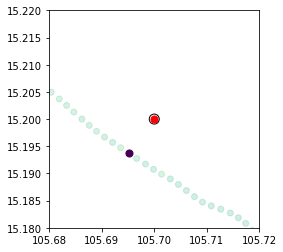

In [24]:
f, ax = plt.subplots()

gdf1_filtered.plot('wse', ax=ax, alpha=0.2)  # plotting the WSE from SWOT
gdf1_filtered.loc[gdf1_filtered['node_id'].values==height['node_id'].values].plot('wse', s=50, ax=ax)
ax.scatter(virtual_station.x, virtual_station.y, marker='o', s=100, ec='black', fc='none')
ax.scatter(height.geometry.x, height.geometry.y, marker='o', s=50, c='red')
plt.xlim(105.68, 105.72)
plt.ylim(15.18, 15.22)
# plt.title(f"Observation Date: {obs_date}")

In [31]:
def get_height(fn, virtual_station_location):
    """Returns the height using the node nearest to the virtual station

    Args:
        fn (str): file path of the _node.shp file
        virtual_station_location (shpely.geoemtry.Point): Point specifying the location of the virtual station

    Returns:
        tuple(pd.Timestamp, ): _description_
    """
    gdf1 = gpd.read_file(fn)

    nodata_val = -999999999999.0
    gdf1_filtered = gdf1[gdf1['wse'] != nodata_val]
    gdf1_filtered['date'] = gdf1_filtered['time_str'].apply(lambda val: pd.to_datetime(val.split('T')[0]))

    virtual_station_gdf = gpd.GeoDataFrame({'name': ['virtual station 1']}, geometry=[virtual_station_location], crs='EPSG:4326')

    obs_date = gdf1_filtered['date'].iloc[0]

    height = virtual_station_gdf.sjoin_nearest(gdf1_filtered)
    
    return obs_date, height['wse'].values[0]

get_height(files[1], virtual_station)

(Timestamp('2021-11-09 00:00:00'), 109.45508)